In [1]:
from load_data import LoadDataset
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Masking, Embedding, LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
selected_features = ['destination_port',
            'init_win_bytes_backward',
            'init_win_bytes_forward',
            'bwd_packets_s',
            'fwd_iat_min',
            'min_seg_size_forward',
            'flow_iat_min',
            'flow_duration',
            'total_length_of_fwd_packets',
            'total_backward_packets',
            'bwd_iat_min',
            'bwd_packet_length_std',
            'fwd_iat_total',
            'fwd_packet_length_mean',
            'fwd_packet_length_max',
            'flow_iat_std',
            'fwd_packets_s',
            'down_up_ratio',
            'total_fwd_packets',
            'bwd_packet_length_min',
            'flow_bytes_s',
            'bwd_header_length',
            'packet_length_mean',
            'total_length_of_bwd_packets',
            "label"]

In [3]:
df_test = LoadDataset("./raw/raw_testset.csv", columns = selected_features, modify_datatype = True)

In [4]:
df_train = LoadDataset("./oversampling/NRAS_trainset.csv", columns = selected_features, modify_datatype = True)

In [5]:
X_train = df_train.drop('label', axis = 1)
y_train = df_train['label']

X_test = df_test.drop('label', axis = 1)
y_test = df_test['label']

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
y_train_categorical = to_categorical(y_train, num_classes = 10)
y_test_categorical = to_categorical(y_test, num_classes = 10)

In [8]:
model = Sequential([
    Dense(128, input_dim = X_train.shape[1], activation = 'relu'),
    Dropout(0.1),
    Dense(256, activation = 'relu'),
    Dropout(0.1),
    Dense(128, activation = 'relu'),
    Dropout(0.1),
    Dense(10, activation = "softmax")
])

In [9]:
opt = Adam(learning_rate = 0.001)
model.compile(loss = 'BinaryCrossentropy', optimizer = opt, metrics = ['accuracy'])

In [10]:
checkpoint = ModelCheckpoint("./checkpoint/dnn_model.h5", 
                             monitor = 'val_loss', verbose = 1, 
                             save_best_only = True, mode = 'min')

In [11]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2,
                                  patience = 3, min_lr = 0.00001)

In [12]:
early_stop_callback = EarlyStopping(monitor = 'loss', patience = 5)

In [13]:
hist = model.fit(X_train, y_train_categorical,
                    batch_size = 64, epochs = 30,
                    callbacks = [reduce_lr, checkpoint],
                    validation_data = (X_test, y_test_categorical))

Epoch 1/30
149059/149062 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9534
Epoch 1: val_loss improved from inf to 0.02172, saving model to ./checkpoint\dnn_model.h5
149062/149062 [==============================] - 770s 5ms/step - loss: 0.0217 - accuracy: 0.9534 - val_loss: 0.0217 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 2/30
149054/149062 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9572
Epoch 2: val_loss improved from 0.02172 to 0.02157, saving model to ./checkpoint\dnn_model.h5
149062/149062 [==============================] - 833s 6ms/step - loss: 0.0196 - accuracy: 0.9572 - val_loss: 0.0216 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 3/30
149061/149062 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9577
Epoch 3: val_loss did not improve from 0.02157
149062/149062 [==============================] - 732s 5ms/step - loss: 0.0196 - accuracy: 0.9577 - val_loss: 0.0219 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 4

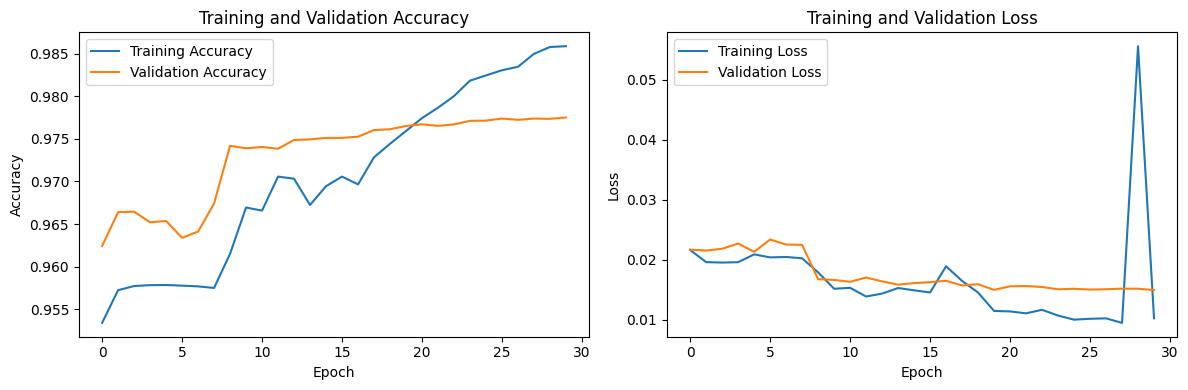

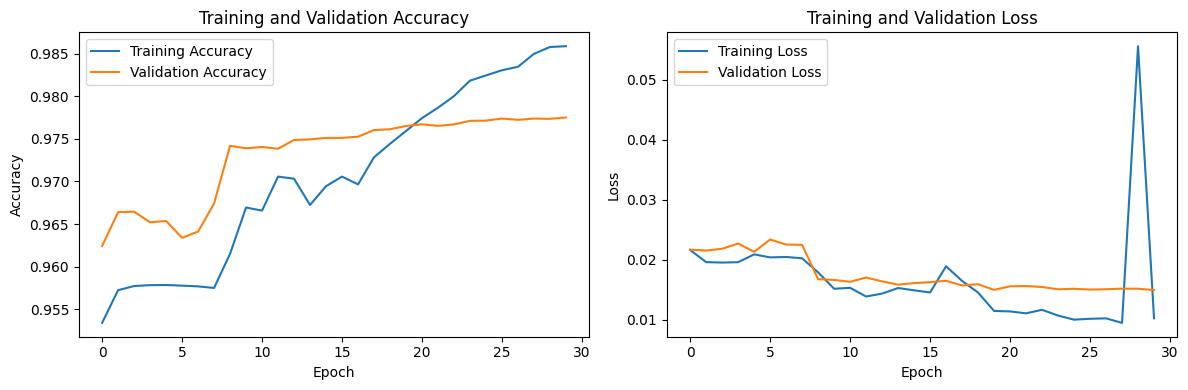

In [23]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
predictions = model.predict(X_test)

23647/23647 [==============================] - 40s 2ms/step


In [19]:
import tensorflow as tf
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = tf.argmax(y_test_categorical, axis=1)

precision_per_class = precision_score(true_labels, predicted_labels, average=None)

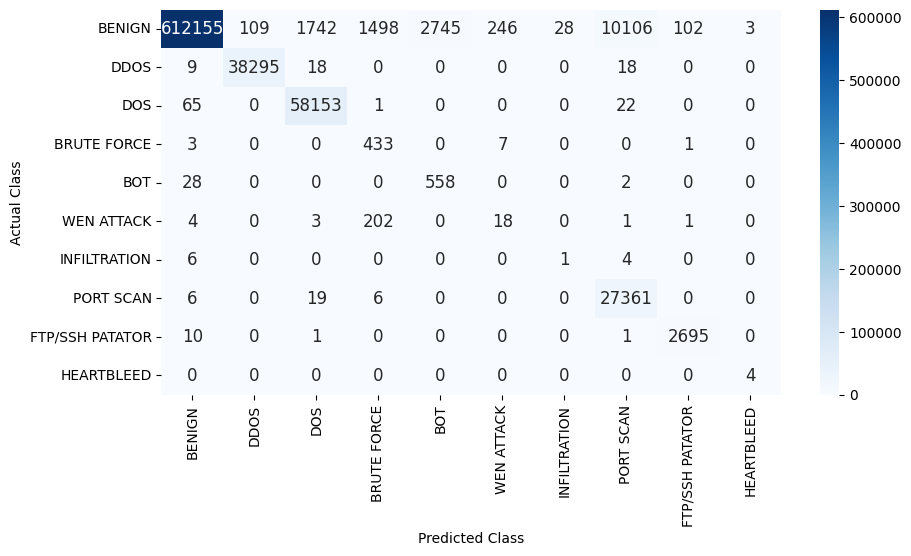

In [22]:
labels = ['BENIGN','DDOS','DOS', 'BRUTE FORCE', 'BOT', 'WEN ATTACK', "INFILTRATION", "PORT SCAN", "FTP/SSH PATATOR", "HEARTBLEED"]

confMat = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(confMat)

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2.4)
sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels = labels, yticklabels = labels, cmap='Blues')

plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 